In [413]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", safety_checker=None)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
pipe.to(device)
pipe.enable_attention_slicing()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


mps


In [414]:
#from transformers import AutoTokenizer, CLIPTextModel

model = pipe.text_encoder.to(device)
input_embeddings = pipe.text_encoder.get_input_embeddings()
tokenizer = pipe.tokenizer

positve_root, negative_root = "make his face more", "make his face less"

root_word = "smug"

root_sentence = f'{positve_root} {root_word}'

synonyms = ["arrogant", "self-satisfied", "condescending", "complacent", "proud"]

antonyms = ["humble", "modest", "timid", "grateful", "diffident"]

synonym_senetences = [f'{positve_root} {synonym}' for synonym in synonyms]

antonym_senetences = [f'{negative_root} {antonym}' for antonym in antonyms]

words = [root_word] + synonyms + antonyms

sentences = [root_sentence] + synonym_senetences + antonym_senetences

print(sentences)

inputs = tokenizer(sentences, padding=True, return_tensors="pt").to(device)

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled (EOS token) states

['make his face more smug', 'make his face more arrogant', 'make his face more self-satisfied', 'make his face more condescending', 'make his face more complacent', 'make his face more proud', 'make his face less humble', 'make his face less modest', 'make his face less timid', 'make his face less grateful', 'make his face less diffident']


In [6]:
type(outputs)

transformers.modeling_outputs.BaseModelOutputWithPooling

In [268]:
type(model)

transformers.models.clip.modeling_clip.CLIPTextModel

In [20]:
print(last_hidden_state.size())
print(pooled_output.size())

torch.Size([11, 9, 768])
torch.Size([11, 768])


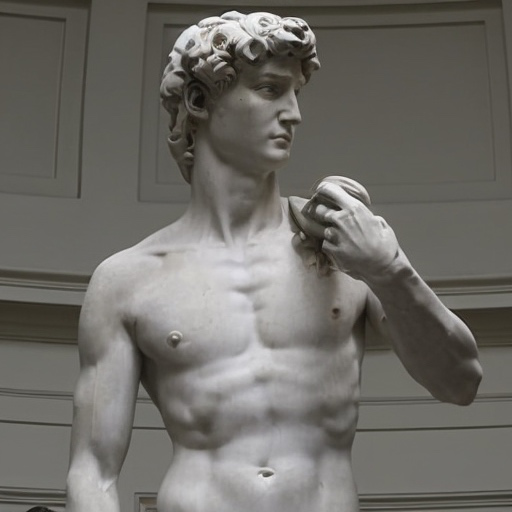

In [14]:
image = PIL.Image.open("./david.jpeg")
image = PIL.ImageOps.exif_transpose(image)
image = image.convert("RGB")
image

In [391]:
from sklearn.decomposition import PCA
import numpy as np

concepts = pooled_output.cpu().detach().numpy()


In [36]:
concepts_centered = concepts - concepts[0]
concepts_centered

array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.788  ,  0.08496, -0.6494 , ..., -0.2974 , -0.503  ,  0.644  ],
       [ 0.329  , -0.02428,  0.5703 , ..., -0.0547 ,  0.3467 ,  0.1411 ],
       ...,
       [ 0.911  ,  0.217  ,  0.2295 , ..., -1.156  ,  0.2046 , -1.197  ],
       [ 0.1846 , -0.3289 ,  0.8984 , ..., -0.8735 , -0.0834 , -0.3198 ],
       [ 0.4375 ,  0.1965 ,  0.3457 , ..., -0.7583 ,  0.0323 , -0.8887 ]],
      dtype=float16)

In [392]:
pca = PCA(n_components=5) # k is the number of components to keep
pca.fit(concepts) # X is the original data in the larger dimensional space
concepts_reduced = pca.transform(concepts)
print(concepts_reduced)

[[-5.79590884  7.84643942 -5.91890243 -5.27624494 -6.67173262]
 [-7.00504246  0.87960079 10.62581026 -0.57992447 -0.45403797]
 [-3.28540936  1.31570233  1.14812641  5.05589    -1.94400955]
 [-2.444204    7.97569409  2.21518444 -2.92042263  8.33789951]
 [ 0.7970942   2.47436444  0.05845357  9.25334389 -1.39173989]
 [-8.67416532 -6.06634486 -9.40439328  1.80718956  5.01432764]
 [-1.48726402 -7.61003396  3.09173862  1.39454813 -1.95594165]
 [ 7.42104547 -4.0221816   1.12632406 -3.68805165  1.03422427]
 [10.19764909  2.74976425 -2.74082407  2.14877952 -1.3098259 ]
 [-0.62890649 -6.2250268   0.51320629 -5.99303846 -2.31568723]
 [10.90511173  0.6820219  -0.71472387 -1.20206896  1.65652339]]


In [38]:
pca.fit(concepts_centered) # X is the original data in the larger dimensional space
concepts_reduced = pca.transform(concepts_centered)
print(concepts_reduced)

[[-5.79632529  7.84660981 -5.91792334 -5.2767875  -6.67192524]
 [-7.00527724  0.87819253 10.62533195 -0.57945377 -0.45330547]
 [-3.28560234  1.31582852  1.14801654  5.05489742 -1.94455733]
 [-2.44434344  7.97533423  2.21616257 -2.920607    8.33753261]
 [ 0.79725898  2.47419467  0.05906689  9.2540443  -1.39166821]
 [-8.67379466 -6.06522481 -9.40516525  1.80741757  5.0147261 ]
 [-1.48727271 -7.6098569   3.09087462  1.39467085 -1.95644128]
 [ 7.42164964 -4.02267421  1.12610059 -3.68833296  1.03395112]
 [10.19733208  2.75019241 -2.740795    2.14935328 -1.30936934]
 [-0.62872025 -6.225607    0.51309266 -5.99263712 -2.31522008]
 [10.90509522  0.68301076 -0.71476223 -1.20256507  1.65627711]]


In [16]:
from torchviz import make_dot

In [28]:
pipe.components

{'vae': AutoencoderKL(
   (encoder): Encoder(
     (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (down_blocks): ModuleList(
       (0): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0): ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
             (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
             (dropout): Dropout(p=0.0, inplace=False)
             (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (nonlinearity): SiLU()
           )
           (1): ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
             (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
             (dropout): Dropout(p=0.0, inplace=False)
             (conv2): Conv2


************FORWARD HO**************

input tensor shape: [torch.Size([1, 77])]
kwargs: {'attention_mask': None}
call stack: 
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
    self.io_loop.start()
File "/opt/homebrew/anaconda3/envs/ip2p2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
File "/opt/homebrew/a

  0%|          | 0/30 [00:00<?, ?it/s]

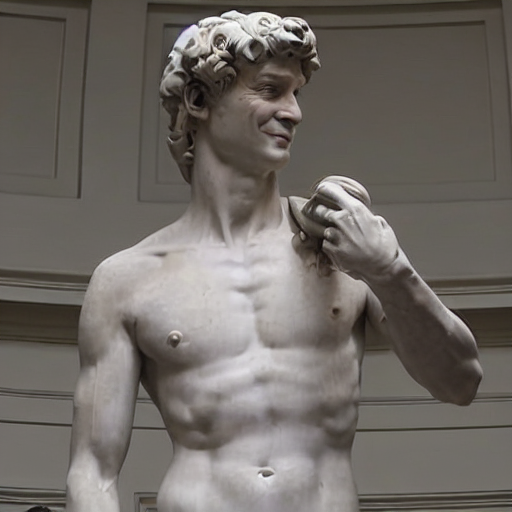

In [510]:
seed = 10101
generator = torch.manual_seed(seed)
prompt = "make his face more smug"
smug = pipe(prompt, image=image, num_inference_steps=30, image_guidance_scale=1.05, generator=generator).images[0]
smug

  0%|          | 0/30 [00:00<?, ?it/s]

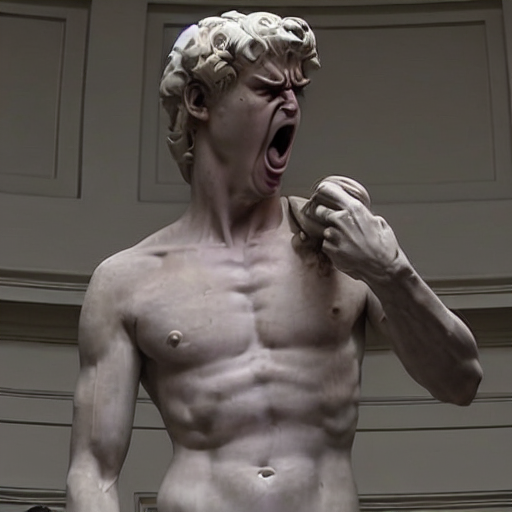

In [444]:
smug_seed = 10101
smug_generator = torch.manual_seed(smug_seed)
complacent = pipe("make his face more angry", image=image, num_inference_steps=30, image_guidance_scale=1.05, generator=smug_generator).images[0]
complacent

In [26]:
# Node Positions
Xn=[concept[0] for concept in concepts_reduced]# x-coordinates of nodes
Yn=[concept[1] for concept in concepts_reduced]# y-coordinates
Zn=[concept[2] for concept in concepts_reduced]# z-coordinates

# Hub and spoke for edges - centered around concept to be tweaked
Xe = [x for i in range(1,11) for x in (concepts_reduced[0][0], concepts_reduced[i][0], None)]# x-coordinates of edge ends
#Ye = [concepts_reduced[0][1], concepts_reduced[i][1], None for i in range(1,11)]# y-coordinates of edge ends
Ye = [y for i in range(1,11) for y in (concepts_reduced[0][1], concepts_reduced[i][1], None)]
Ze = [z for i in range(1,11) for z in (concepts_reduced[0][2], concepts_reduced[i][2], None)]

In [28]:
colors = [concept[3] for concept in concepts_reduced]

In [184]:
node_freqs = [concept[4] for concept in concepts_reduced]
node_freqs 

[-6.671925235153615,
 -0.45330546857060555,
 -1.9445573283719,
 8.337532611990262,
 -1.3916682092858894,
 5.014726099818912,
 -1.9564412836279894,
 1.033951123824349,
 -1.3093693421826913,
 -2.315220076768004,
 1.6562771083271712]

In [233]:
# Assume units in HZ

# Total duration 20 sec, therfore we would see 2 cycles of the slowest and 40 cycles of the fastet
# 1200 total frames

frame_count = 60*20
frame_duration = 1/60 # 60 FPS 
min_freq = 0.1 # ~4 Breaths in 30 sec
max_freq = 1

In [227]:
import igraph as ig
#import plotly.plotly as py
import plotly.offline as py
import plotly.graph_objs as go

In [169]:
frame_idxs = np.arange(0, 61, 1)

In [234]:
min_node_size = 22
max_node_size = 66
size_scale_factor = max_node_size - min_node_size

def get_vibes(freqs, frame_idx):
    return (np.sin(freqs*2*np.pi*frame_idx*frame_duration- np.pi/2)+1)/2

def scale_freqs(freqs):
    min_raw_freq= min(freqs)
    max_raw_freq= max(freqs)
    old_range = max_raw_freq - min_raw_freq
    scaled_range = max_freq - min_freq
    return np.array((((freqs - min_raw_freq) * scaled_range) / old_range) + min_freq)

In [235]:
# Scale frequencies
scaled_node_freqs = scale_freqs(node_freqs)
print(scaled_node_freqs)
print(min_node_size + get_vibes(scaled_node_freqs, 0)*size_scale_factor)

[0.1        0.47288208 0.38346334 1.         0.41661579 0.80075724
 0.38275076 0.56206124 0.42155061 0.36123759 0.59937727]
[22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22.]


In [237]:

edge_trace =    go.Scatter3d(x=Xe, y=Ye, z=Ze,
                    mode='lines',
                    line=dict(color='rgb(125,125,125)', width=5),
                    hoverinfo='none'
                )

node_trace =    go.Scatter3d( x=Xn, y=Yn, z=Zn,
                    mode='markers',
                    name='concepts',
                    marker= dict (
                                symbol='circle',
                                size=22,
                                color=colors,
                                colorscale='Viridis',
                                line=dict(color='rgb(50,50,50)', width=5)
                            ),
                    text=sentences,
                    hoverinfo='text'
                )

axis=   dict(
            showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title=''
        )

layout = go.Layout(
            title="Concepts surrounding smugness",
            width=1000,
            height=1000,
            showlegend=False,
            scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
                zaxis=dict(axis),
            ),
            updatemenus=[ 
                dict(
                    type="buttons",
                    buttons=[dict(
                                label="Play",
                                method="animate",
                                args=[None, {"frame": {"duration": frame_duration*1000, "redraw": True}}]
                            )]
                )
            ],
            margin=dict(
                t=100
            ),
            hovermode='closest',
            annotations=[
                dict(
                showarrow=False,
                    text="Hello world",
                    xref='paper',
                    yref='paper',
                    x=0,
                    y=0.1,
                    xanchor='left',
                    yanchor='bottom',
                    font=dict(
                        size=14
                    )
                )
            ],    
        )

In [238]:
frames=[go.Frame(
        data=[
            go.Scatter3d( x=Xn, y=Yn, z=Zn,
                    mode='markers',
                    name='concepts',
                    marker= dict (
                                symbol='circle',
                                size=min_node_size + get_vibes(scaled_node_freqs, i)*size_scale_factor,
                                color=colors,
                                colorscale='Viridis',
                                line=dict(color='rgb(50,50,50)', width=5)
                            ),
                    text=sentences,
                    hoverinfo='text'
            ),
            edge_trace
        ]
    ) for i in range(frame_count+1)]
print(len(frames))

1201


In [239]:
data=[edge_trace, node_trace]
fig=go.Figure(data=data, layout=layout, frames=frames)
py.iplot(fig, filename='smugness')

In [267]:
# train, training
type(model.train)
type(model)

transformers.models.clip.modeling_clip.CLIPTextModel

Build function that parameterizes the desired output embedding
Need to update BaseModelOutputWithPooling with desired embedding for output

In [351]:
new_output = outputs.copy()

In [473]:
def get_scaled_adjustment(source_tensor, target_tensor, scale_factor):
    return torch.multiply(torch.subtract(target_tensor, source_tensor), scale_factor)
    #return torch.multiply(torch.subtract(new_output.pooler_output[5], new_output.pooler_output[0]), scale_factor)

In [497]:
pooled_adjustment = get_scaled_adjustment(torch.index_select(new_output.pooler_output, 0, torch.tensor([0]).to(device)), torch.index_select(new_output.pooler_output, 0, torch.tensor([5]).to(device)), 0.5)
print(pooled_adjustment.size())

last_layer_adjustment = get_scaled_adjustment(torch.index_select(new_output.last_hidden_state, 0, torch.tensor([0]).to(device)), torch.index_select(new_output.last_hidden_state, 0, torch.tensor([5]).to(device)), 51)
print(last_layer_adjustment.size())
print(last_layer_adjustment.size(1))

torch.Size([1, 768])
torch.Size([1, 9, 768])
9


In [483]:
test_one = torch.rand([3, 5, 7])
test_two = torch.ones([1, 5, 7])
test_broadcast = torch.add(test_one, test_two)
print(test_broadcast.size())

torch.Size([3, 5, 7])


In [415]:
#Test reproduceability
smug_pompt_tokenized = tokenizer(prompt, padding=True, return_tensors="pt").to(device)

smug_embedding_output = model(**smug_pompt_tokenized)
smug_pooled_output = smug_embedding_output.pooler_output.cpu().detach().numpy()
smug_pooled_output[0][0:9]

array([-1.841  ,  0.02501,  1.482  ,  0.3784 ,  2.648  ,  0.494  ,
        0.8926 , -0.1467 , -0.4736 ], dtype=float16)

In [502]:
import traceback

In [508]:
def new_forward(self, *args, **kwargs):
    
    print ("\n************FORWARD HO**************\n")

    print(f'input tensor shape: {[arg.size() for arg in args]}')
    print(f'kwargs: {kwargs}')
    print(f'call stack: ')

    for line in traceback.format_stack():
        print(line.strip())

    prev_output = self.text_model(*args, **kwargs)

    #print(f'prev_10_output: {prev_output.pooler_output[0][0:9]}')

    prev_output.pooler_output = torch.add(prev_output.pooler_output, pooled_adjustment)

    #print(f'old last layer size: {prev_output.last_hidden_state.size()}')

    if (prev_output.last_hidden_state.size(1) != 77):
    
        new_last_layer = torch.add(prev_output.last_hidden_state, last_layer_adjustment)

        #print(f'new last layer size: {new_last_layer.size()}')

        prev_output.last_hidden_state = new_last_layer
    
    
    print(f'adj_10_output: {prev_output.pooler_output[0][0:9]}')

    print ("\n************OH YEAH**************\n")

    return prev_output

In [436]:
type(pipe)

diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline

In [509]:


forward_method_type = type(model.forward)

model.forward = forward_method_type(new_forward, model)

pipe.register_modules(text_encoder = model)

In [456]:
#Test update to forward method
smug_pompt_tokenized = tokenizer(prompt, padding=True, return_tensors="pt").to(device)

smug_embedding_output = model(**smug_pompt_tokenized)
smug_pooled_output = smug_embedding_output.pooler_output.cpu().detach().numpy()
smug_pooled_output[0][0:9]
# array([-1.841  ,  0.02501,  1.482  ,  0.3784 ,  2.648  ,  0.494  , 0.8926 , -0.1467 , -0.4736 ], dtype=float16)



************YEAH**************




array([  6.99 ,   2.951,   2.303,  21.75 , -21.38 ,   7.773,   7.33 ,
       -14.27 ,  10.12 ], dtype=float16)

In [492]:
type(pipe.components)

dict

In [2]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Make his face more smug")
displacy.serve(doc, style="dep")

OSError: [Errno 48] Address already in use